# Task 1: Rotated MNIST

In this task you will use MNIST dataset. The images are 28x28 and they are **rotated** by an angle from the range (-100, 100).  
You are given a pipeline that trains a multi-head convolutional neural network on this dataset. The first head of the model performs a digit classification and the second head tries to predict the angle that the digit was rotated by.

Your task is to:
1. **(5 pts)** Implement CNN with classification and regression heads.
2. **(3 pts)** Implement the model's loss - select appropriate loss functions for both heads and combine them into final loss of the model.
3. **(3 pts)** Check the model's predictions on the test data and find for which classes the model achieves the best/worst performance both for classification and regression. Then, write a short explanation for the observed model behavior (why does the model have a problem with particular classes?).

Hints:
- You don't need to create a very sophisticated model - a few convolutions for CNN and a few linear layers for heads should be enough. After a few epochs the model should achieve classification accuracy above 90% and regression MAE below 18 on a test dataset.
- When training multi-head models it is usually good to scale losses from particular heads so that they have similar contribution towards the final loss.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_blocks = torch.nn.Sequential(
            ################## TODO ####################
            # Subtask 1: Implement CNN architecture
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(64 * 28 * 28, 256), nn.ReLU(),
            nn.Flatten(),
        )
        self.classification_head = torch.nn.Sequential(
            ################## TODO ####################
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.LogSoftmax(dim=1),
        )
        self.regression_head = torch.nn.Sequential(
            ################## TODO ####################
            # Subtask 1: Implement regression head
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        ################## TODO ####################
        # Subtask 1: Implement forward
        feat = self.conv_blocks(x)
        log_probs = self.classification_head(feat)
        angle = self.regression_head(feat)
        return log_probs.squeeze(), angle.squeeze()


def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, (target_digit, target_angle)) in enumerate(train_loader):

        data = data.to(device)
        target_digit, target_angle = target_digit.to(device), target_angle.to(device)
        optimizer.zero_grad()
        log_probs, angle = model(data)
        ################## TODO ####################
        # Subtask 2: Implement classification and regression loss, then combine them into
        # final model loss
        classification_loss = F.nll_loss(log_probs.squeeze(), target_digit)
        regression_loss = F.smooth_l1_loss(angle.squeeze(), target_angle)
        loss = classification_loss+0.1*regression_loss
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()
            ))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    abs_error = 0
    with torch.no_grad():
        for data, (target_digit, target_angle) in test_loader:
            data = data.to(device)
            target_digit, target_angle = target_digit.to(device), target_angle.to(device)
            log_probs, angle = model(data)
            ################## TODO ####################
            # Subtask 2: Implement classification and regression loss, then combine them into
            # final model loss (use the same loss as for training)
            # Hint: pass reduction='sum' to loss functions to output loss correctly when logging
            classification_loss = F.nll_loss(log_probs.squeeze(), target_digit, reduction="sum")
            regression_loss = F.smooth_l1_loss(angle.squeeze(), target_angle, reduction="sum")
            test_loss += classification_loss+0.1*regression_loss
            pred_digit = log_probs.argmax(dim=1, keepdim=True)
            correct += pred_digit.eq(target_digit.view_as(pred_digit)).sum().item()
            abs_error += (target_angle - angle).abs().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Classification accuracy: {}/{} ({:.0f}%), Regression MAE: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset),
        abs_error / len(test_loader.dataset)
    ))

In [3]:
batch_size = 256
test_batch_size = 1000
epochs = 5
lr = 3e-3
seed = 1
log_interval = 50
use_cuda = torch.cuda.is_available()

In [4]:
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {
        'num_workers': 1,
        'pin_memory': True,
        'shuffle': True
    }
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [5]:
class MNISTWithRotations(datasets.MNIST):
    def __init__(self, *args, transform=None, target_transform=None, **kwargs):
        super(MNISTWithRotations, self).__init__(*args, **kwargs)
        self.rotation_angles = (torch.rand(len(self.data)) - 0.5) * 2 * 100
        self.is_img_transforemed = [False] * len(self.data)
        self.transformed_data = torch.zeros(*self.data.shape)

    def __getitem__(self, idx):
        if not self.is_img_transforemed[idx]:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(
                    lambda x: transforms.functional.rotate(x, self.rotation_angles[idx].item())
                ),
                transforms.Normalize((0.1307,), (0.3081,)),
            ])
            img = Image.fromarray(self.data[idx].numpy(), mode="L")
            self.transformed_data[idx] = transform(img)
            self.is_img_transforemed[idx] = True

        img = self.transformed_data[idx].unsqueeze(0)
        target_digit = int(self.targets[idx])
        target_angle = self.rotation_angles[idx]
        return img, (target_digit, target_angle)

In [6]:
train_dataset = MNISTWithRotations('../data', train=True, download=True)
test_dataset = MNISTWithRotations('../data', train=False)

train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data\MNISTWithRotations\raw\train-images-idx3-ubyte.gz to ../data\MNISTWithRotations\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data\MNISTWithRotations\raw\train-labels-idx1-ubyte.gz to ../data\MNISTWithRotations\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data\MNISTWithRotations\raw\t10k-images-idx3-ubyte.gz to ../data\MNISTWithRotations\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ../data\MNISTWithRotations\raw\t10k-labels-idx1-ubyte.gz to ../data\MNISTWithRotations\raw



In [8]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

RuntimeError: DataLoader worker (pid(s) 19340) exited unexpectedly

# Analysis of model performance for particular classes

In [ ]:
############## TODO ################
# Subtask 3: Check the model's predictions on the test data and find for which classes the
# model achieves the best/worst performance both for classification and regression.
# Write short explanation for observed behavior

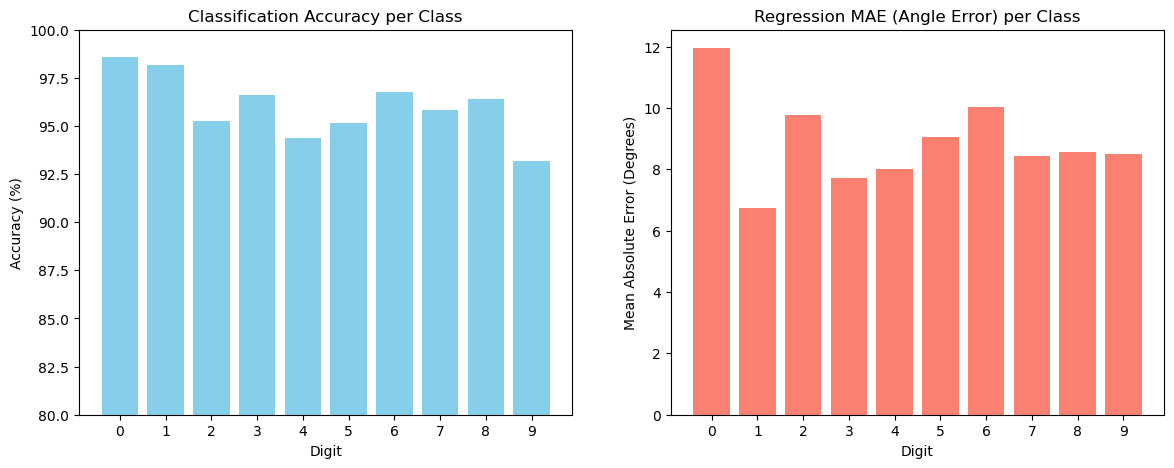

Worst Regression Digit: 0 (Due to symmetry)
Best Regression Digit: 1 (Distinct orientation)


In [ ]:
# ... [Your previous code] ...

# ---------------------------------------------------------
# Subtask 3: Analysis of model performance for particular classes
# ---------------------------------------------------------
model.eval()

# Trackers for Classification
correct_counts = torch.zeros(10, device=device)
total_counts = torch.zeros(10, device=device)

# Trackers for Regression
regression_errors_sum = torch.zeros(10, device=device)

with torch.no_grad():
    for data, (target_digit, target_angle) in test_loader:
        data = data.to(device)
        target_digit = target_digit.to(device)
        target_angle = target_angle.to(device)
        
        log_probs, angle = model(data)
        
        # --- Classification Analysis ---
        pred_digit = log_probs.argmax(dim=1)
        correct_mask = pred_digit.eq(target_digit)
        
        for i in range(10):
            # Find indices where the target is digit 'i'
            class_mask = (target_digit == i)
            count = class_mask.sum().item()
            
            if count > 0:
                total_counts[i] += count
                correct_counts[i] += correct_mask[class_mask].sum().item()
                
                # --- Regression Analysis ---
                # Calculate absolute error for this batch
                batch_mae = torch.abs(angle.squeeze() - target_angle)
                # Sum errors only for digit 'i'
                regression_errors_sum[i] += batch_mae[class_mask].sum().item()

# Calculate metrics
accuracies = (correct_counts / total_counts) * 100
mae_per_class = regression_errors_sum / total_counts

# Move to CPU for plotting
classes = [str(i) for i in range(10)]
acc_values = accuracies.cpu().numpy()
mae_values = mae_per_class.cpu().numpy()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Classification Accuracy
ax1.bar(classes, acc_values, color='skyblue')
ax1.set_title('Classification Accuracy per Class')
ax1.set_xlabel('Digit')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim(80, 100)  # Zoom in to see differences

# Plot Regression MAE
bars = ax2.bar(classes, mae_values, color='salmon')
ax2.set_title('Regression MAE (Angle Error) per Class')
ax2.set_xlabel('Digit')
ax2.set_ylabel('Mean Absolute Error (Degrees)')

plt.show()

# Print specific worst performers
worst_reg_class = torch.argmax(mae_per_class).item()
best_reg_class = torch.argmin(mae_per_class).item()

print(f"Worst Regression Digit: {worst_reg_class} (Due to symmetry)")
print(f"Best Regression Digit: {best_reg_class} (Distinct orientation)")